## Library Installation

In [19]:
"""!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install opencv-python
!pip install matplotlib
!pip install seaborn
!pip install tensorflow # Or !pip install torch torchvision torchaudio
!pip install Pillow"""

'!pip install numpy\n!pip install pandas\n!pip install scikit-learn\n!pip install opencv-python\n!pip install matplotlib\n!pip install seaborn\n!pip install tensorflow # Or !pip install torch torchvision torchaudio\n!pip install Pillow'

## Importing Libraries

In [20]:
# %% [markdown]
# # BBM 409 - Assignment 4: Bird Species Classification
# ## Part 0: Data Loading, Preprocessing, and Visualization
# %% Setup: Imports and Global Parameters
import os
import cv2 # OpenCV for image manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # For one-hot encoding
import random
import pandas as pd
from sklearn.manifold import TSNE # For t-SNE visualization
from sklearn.preprocessing import StandardScaler # For t-SNE
from skimage.feature import hog, local_binary_pattern # <-- YENİ EKLEME
# --- USER CONFIGURABLE PARAMETERS ---
# !!! IMPORTANT: SET THIS TO YOUR DATASET PATH !!!
DATASET_BASE_DIR = 'Birds_25'  # Path to your 'Birds_25' directory

# Image dimensions for model input
IMG_WIDTH = 28
IMG_HEIGHT = 28

NUM_CLASSES = 25 # As per the assignment
# --- END USER CONFIGURABLE PARAMETERS ---

TRAIN_DIR = os.path.join(DATASET_BASE_DIR, 'train')
VALID_DIR = os.path.join(DATASET_BASE_DIR, 'valid')

## PART 0: DATA VISUALIZATION AND DATA PREPROCESSING

### Step 1: Discover Species and Collect Image Paths

In [21]:
# %% [markdown]

# %% Step 1 Code
species_list = []
if os.path.exists(TRAIN_DIR):
    species_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
else:
    print(f"Warning: Training directory not found at '{TRAIN_DIR}'. Cannot determine species list automatically.")

if not species_list:
    print("Species list is empty. Please ensure your dataset is structured correctly and DATASET_BASE_DIR is set.")
else:
    print(f"Found {len(species_list)} species: {species_list[:5]}... (first 5 shown)")
    if len(species_list) != NUM_CLASSES:
        print(f"Warning: Found {len(species_list)} species folders, but expected {NUM_CLASSES}.")

all_original_train_paths = []
all_original_train_labels_str = []
all_original_valid_paths = []
all_original_valid_labels_str = []

for species_name in species_list:
    species_train_dir = os.path.join(TRAIN_DIR, species_name)
    if os.path.isdir(species_train_dir):
        for img_file in os.listdir(species_train_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_train_paths.append(os.path.join(species_train_dir, img_file))
                all_original_train_labels_str.append(species_name)

    species_valid_dir = os.path.join(VALID_DIR, species_name)
    if os.path.isdir(species_valid_dir):
        for img_file in os.listdir(species_valid_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_valid_paths.append(os.path.join(species_valid_dir, img_file))
                all_original_valid_labels_str.append(species_name)

print(f"\nTotal original training image paths collected: {len(all_original_train_paths)}")
print(f"Total original validation image paths collected: {len(all_original_valid_paths)}")

Found 25 species: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']... (first 5 shown)

Total original training image paths collected: 30000
Total original validation image paths collected: 7500


### Step 2: Encode Labels and Prepare 80-10-10 Split Paths


In [22]:
# %% Step 2 Code
label_encoder = LabelEncoder()
all_original_train_labels_encoded = label_encoder.fit_transform(all_original_train_labels_str)
all_original_valid_labels_encoded = label_encoder.transform(all_original_valid_labels_str)

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nLabel mapping (numerical_label: species_name):")
for i in range(min(5, len(label_mapping))): # Print first 5
    print(f"{i}: {label_mapping[i]}")
if len(label_mapping) > 5: print("...")


X_train_paths = []
y_train_labels_encoded = []
X_val_paths = []
y_val_labels_encoded = []
X_test_paths = []
y_test_labels_encoded = []

# Populate final training set (all original training images)
for i in range(len(all_original_train_paths)):
    X_train_paths.append(all_original_train_paths[i])
    y_train_labels_encoded.append(all_original_train_labels_encoded[i])

# Split original validation images per class into new validation and test sets
original_valid_paths_by_class = {}
for path, label_enc in zip(all_original_valid_paths, all_original_valid_labels_encoded):
    if label_enc not in original_valid_paths_by_class:
        original_valid_paths_by_class[label_enc] = []
    original_valid_paths_by_class[label_enc].append(path)

for class_label_enc, paths_for_class in original_valid_paths_by_class.items():
    species_name_temp = label_encoder.inverse_transform([class_label_enc])[0]
    if len(paths_for_class) != 300: # As per dataset description
        print(f"Info: Species '{species_name_temp}' has {len(paths_for_class)} original validation images (expected 300). Adjusting split.")
    
    random.shuffle(paths_for_class)
    split_point = len(paths_for_class) // 2

    X_val_paths.extend(paths_for_class[:split_point])
    y_val_labels_encoded.extend([class_label_enc] * len(paths_for_class[:split_point]))
    X_test_paths.extend(paths_for_class[split_point:])
    y_test_labels_encoded.extend([class_label_enc] * len(paths_for_class[split_point:]))

print(f"\n--- Dataset Split Path Counts ---")
print(f"Final training image paths: {len(X_train_paths)}")
print(f"Final validation image paths: {len(X_val_paths)}")
print(f"Final test image paths: {len(X_test_paths)}")

y_train_labels_encoded = np.array(y_train_labels_encoded)
y_val_labels_encoded = np.array(y_val_labels_encoded)
y_test_labels_encoded = np.array(y_test_labels_encoded)



Label mapping (numerical_label: species_name):
0: Asian-Green-Bee-Eater
1: Brown-Headed-Barbet
2: Cattle-Egret
3: Common-Kingfisher
4: Common-Myna
...

--- Dataset Split Path Counts ---
Final training image paths: 30000
Final validation image paths: 3750
Final test image paths: 3750


### Step 3: Image Loading and Preprocessing Functions (Separated)


In [23]:
# %% Step 3 Code
def load_raw_image_from_path(image_path):
    try:
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            print(f"Warning (load_raw_image_from_path): Could not read image {image_path}.")
            return None
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb
    except Exception as e:
        print(f"Error loading raw image {image_path}: {e}")
        return None

def apply_model_preprocessing(raw_image_rgb, target_width, target_height):
    if raw_image_rgb is None: return None
    try:
        img_resized = cv2.resize(raw_image_rgb, (target_width, target_height))
        img_normalized = img_resized.astype('float32') / 255.0
        return img_normalized
    except Exception as e:
        print(f"Error applying model preprocessing: {e}")
        return None

def load_and_preprocess_data_separated(image_paths_list, labels_encoded_list, target_width, target_height):
    data, labels = [], []
    print(f"Starting to load and preprocess {len(image_paths_list)} images...")
    for i, path in enumerate(image_paths_list):
        raw_img = load_raw_image_from_path(path)
        if raw_img is not None:
            processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
            if processed_img is not None:
                data.append(processed_img)
                labels.append(labels_encoded_list[i])
        if (i + 1) % 500 == 0 or (i + 1) == len(image_paths_list):
             print(f"  Processed {i+1}/{len(image_paths_list)} images for current set.")
    print(f"Finished. Successfully processed {len(data)} out of {len(image_paths_list)} images.")
    return np.array(data), np.array(labels)

# %% [markdown]


### Step 4: Visualization Functions


In [25]:

# %% Step 4 Code
def display_sample_images_from_paths(image_paths_list, numeric_labels_list, label_mapping_dict,
                                     num_samples_per_class=3, num_classes_to_display=5, title_prefix="Sample Raw"):
    if not image_paths_list or not numeric_labels_list.size:
        print("Image paths list or labels list is empty.")
        return

    paths_by_class = {}
    for path, label_numeric in zip(image_paths_list, numeric_labels_list):
        if label_numeric not in paths_by_class: paths_by_class[label_numeric] = []
        paths_by_class[label_numeric].append(path)

    unique_labels_available = list(paths_by_class.keys())
    if not unique_labels_available: return

    selected_labels_numeric = random.sample(unique_labels_available, min(num_classes_to_display, len(unique_labels_available)))

    plt.figure(figsize=(15, 3 * len(selected_labels_numeric)))
    plot_idx = 1
    for label_numeric in selected_labels_numeric:
        class_name = label_mapping_dict.get(label_numeric, f"Unknown {label_numeric}")
        class_image_paths = paths_by_class.get(label_numeric, [])
        sample_paths = random.sample(class_image_paths, min(num_samples_per_class, len(class_image_paths)))
        for i, img_path in enumerate(sample_paths):
            plt.subplot(len(selected_labels_numeric), num_samples_per_class, plot_idx)
            raw_img_to_display = load_raw_image_from_path(img_path)
            if raw_img_to_display is not None:
                plt.imshow(raw_img_to_display)
                plt.title(f"{title_prefix}: {class_name}\n(Original Dim.)")
            else:
                plt.title(f"{class_name}\nFailed to load")
            plt.axis('off')
            plot_idx += 1
    plt.suptitle(f"{title_prefix} Images Per Class", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

def plot_class_distribution(y_numeric_list, label_mapping_dict, dataset_name="Dataset"):
    if not y_numeric_list.size:
        print(f"Label array for {dataset_name} is empty.")
        return
    unique_labels, counts = np.unique(y_numeric_list, return_counts=True)
    class_names = [label_mapping_dict.get(label, f"Unknown {label}") for label in unique_labels]
    
    df_counts = pd.DataFrame({'Species': class_names, 'Count': counts}).sort_values('Species')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")
    plt.title(f'Class Distribution in {dataset_name} (Total: {sum(counts)} images)', fontsize=15)
    plt.xlabel('Bird Species', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def show_downscaling_effect_from_path(original_image_path, target_width, target_height):
    raw_img = load_raw_image_from_path(original_image_path)
    if raw_img is None:
        print(f"Could not load image for downscaling demo: {original_image_path}")
        return
    
    # Preprocess for downscaled version
    processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
    if processed_img is None:
        print(f"Could not preprocess image for downscaling demo: {original_image_path}")
        return

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title(f'Original Image\n({raw_img.shape[1]}x{raw_img.shape[0]})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img) # This is normalized, imshow handles [0,1] floats
    plt.title(f'Downscaled & Normalized\n({target_width}x{target_height})')
    plt.axis('off')
    plt.suptitle("Image Downscaling and Preprocessing Effect", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def display_average_processed_images(X_processed, y_numeric_list, label_mapping_dict, num_classes_to_display=5):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for average image display.")
        return
    unique_labels = np.unique(y_numeric_list)
    selected_labels = random.sample(list(unique_labels), min(num_classes_to_display, len(unique_labels)))
    
    plt.figure(figsize=(15, 3))
    for i, label_numeric in enumerate(selected_labels):
        class_images = X_processed[y_numeric_list == label_numeric]
        if class_images.shape[0] == 0: continue
        average_image = np.mean(class_images, axis=0)
        average_image = np.clip(average_image, 0, 1) # Ensure vals are in [0,1]

        plt.subplot(1, len(selected_labels), i + 1)
        plt.imshow(average_image)
        plt.title(f"Avg: {label_mapping_dict.get(label_numeric, str(label_numeric))}")
        plt.axis('off')
    plt.suptitle("Average Processed Images Per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_color_histograms_for_raw_image(raw_image_rgb, title="Color Histogram"):
    if raw_image_rgb is None: return
    colors, channel_names = ('r', 'g', 'b'), ('Red', 'Green', 'Blue')
    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=14)
    for i, color in enumerate(colors):
        # Ensure image is uint8 for calcHist if it's not already
        img_for_hist = raw_image_rgb
        if raw_image_rgb.dtype != np.uint8:
             # If it was float [0,1] for some reason, scale. But load_raw_image should give uint8.
             if raw_image_rgb.max() <= 1.0 and raw_image_rgb.min() >=0.0 :
                 img_for_hist = (raw_image_rgb * 255).astype(np.uint8)
             else: # Assume it's already in a good range for uint8 conversion
                 img_for_hist = raw_image_rgb.astype(np.uint8)

        histogram = cv2.calcHist([img_for_hist], [i], None, [256], [0, 256])
        plt.plot(histogram, color=color, label=f'{channel_names[i]} channel')
    plt.xlabel("Pixel Intensity (0-255)"); plt.ylabel("Number of Pixels")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.xlim([0, 256])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_tsne_visualization_of_processed(X_processed, y_numeric_list, label_mapping_dict, n_samples_subset=1000, perplexity_val=30):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for t-SNE.")
        return
    actual_samples = min(n_samples_subset, X_processed.shape[0])
    if actual_samples < perplexity_val + 2 : # Perplexity must be less than n_samples - 1
        print(f"Subset size {actual_samples} is too small for perplexity {perplexity_val}. Skipping t-SNE or try larger subset/smaller perplexity.")
        return
        
    print(f"\nPerforming t-SNE on a subset of {actual_samples} processed samples...")
    indices = np.random.choice(X_processed.shape[0], actual_samples, replace=False)
    X_subset, y_subset = X_processed[indices], y_numeric_list[indices]
    X_flattened = X_subset.reshape(actual_samples, -1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity_val, actual_samples-2), n_iter=300, verbose=0)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(14, 10))
    unique_labels_in_subset = np.unique(y_subset)
    cmap = plt.cm.get_cmap('turbo', len(unique_labels_in_subset))

    for i, label_numeric in enumerate(unique_labels_in_subset):
        class_name = label_mapping_dict.get(label_numeric, str(label_numeric))
        plt.scatter(X_tsne[y_subset == label_numeric, 0], X_tsne[y_subset == label_numeric, 1],
                    label=class_name, alpha=0.8, color=cmap(i), s=50)
    plt.title(f't-SNE Visualization of {actual_samples} Processed Image Samples', fontsize=15)
    plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
    if len(unique_labels_in_subset) <= 25: # Adjust if too many for legend
        plt.legend(loc='best', markerscale=1.0, bbox_to_anchor=(1.05, 1), title="Species")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make space for legend
    plt.show()


### Step 5: Data Visualizations of Original Data



--- Displaying Sample Raw Images from Training Paths ---


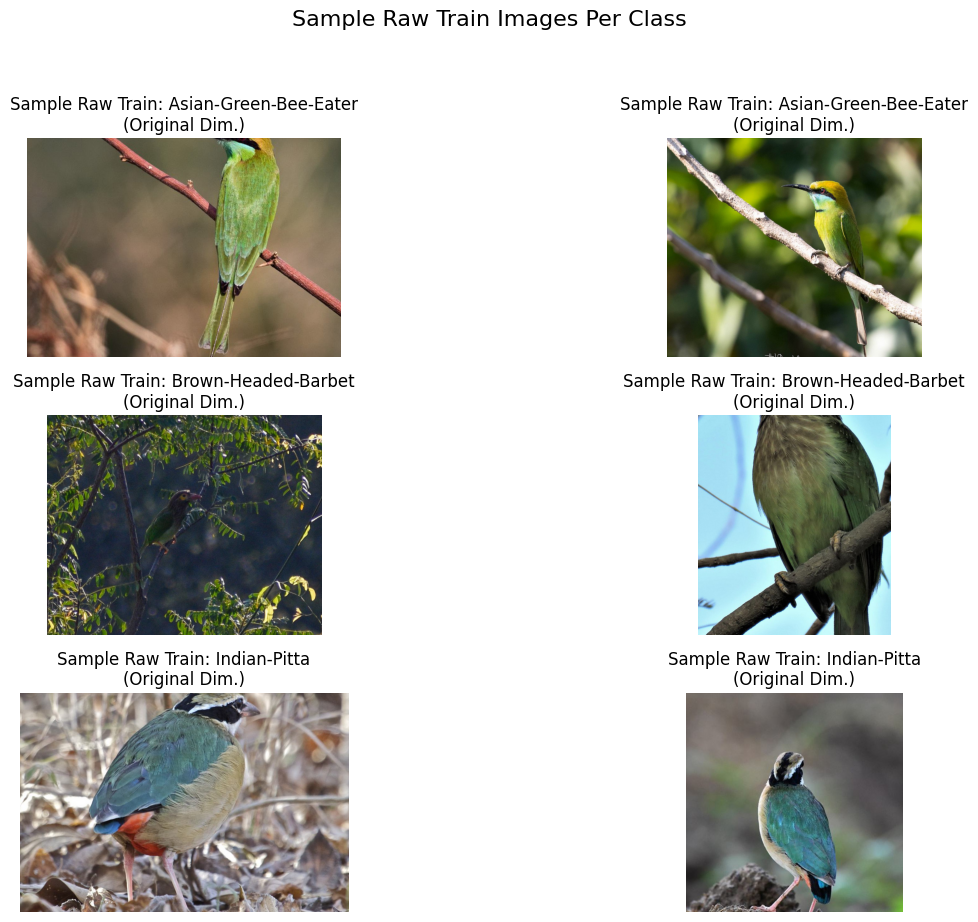


--- Displaying Downscaling Effect (using one training sample) ---


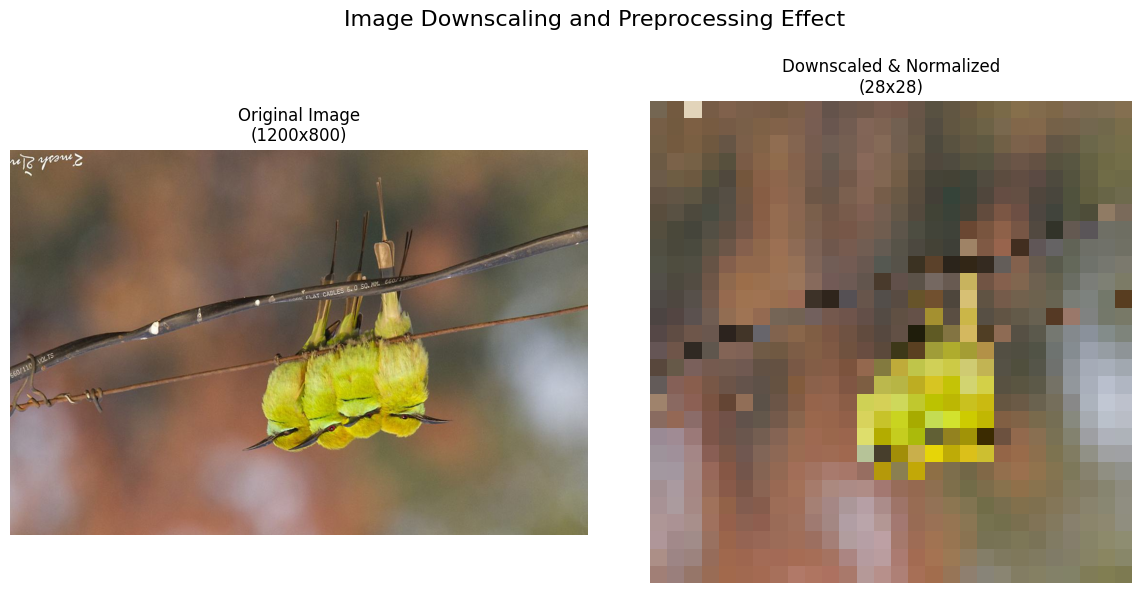


--- Displaying Color Histograms for a few Raw Training Samples ---


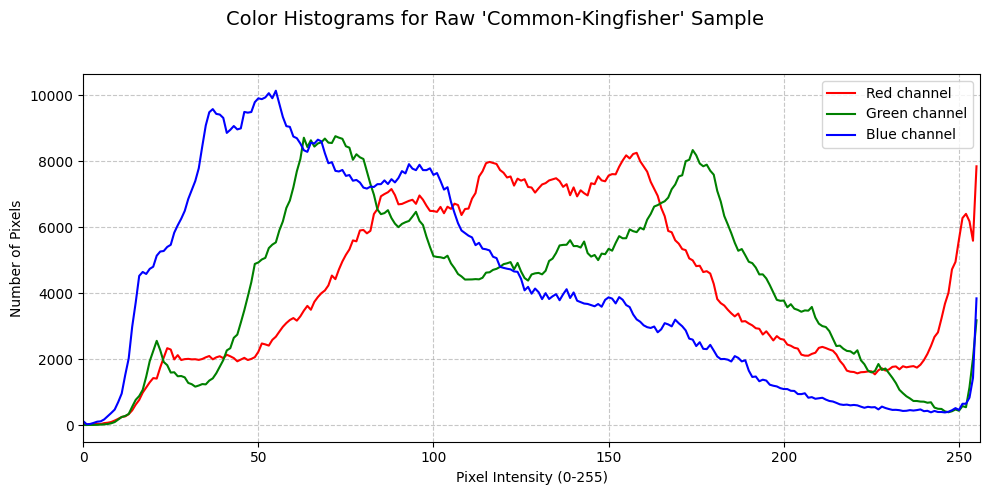

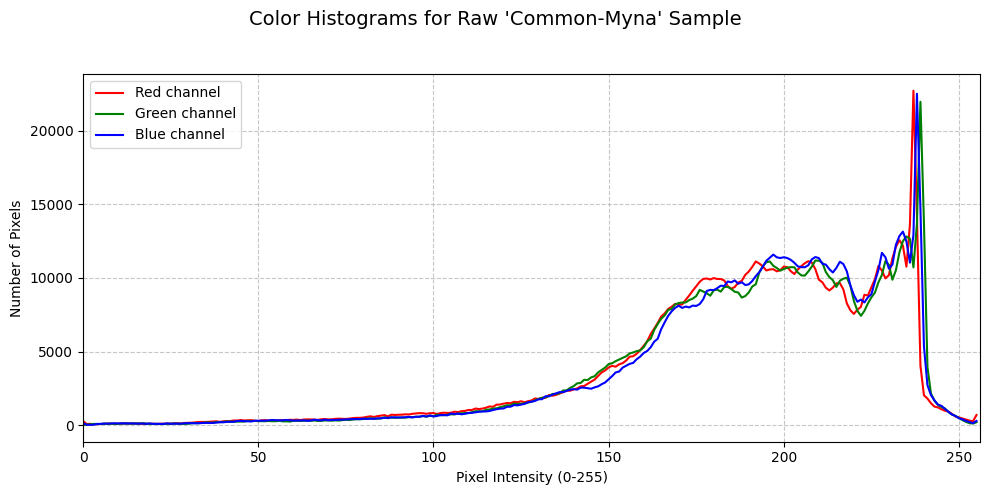


--- Plotting Class Distributions (based on path counts) ---


/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


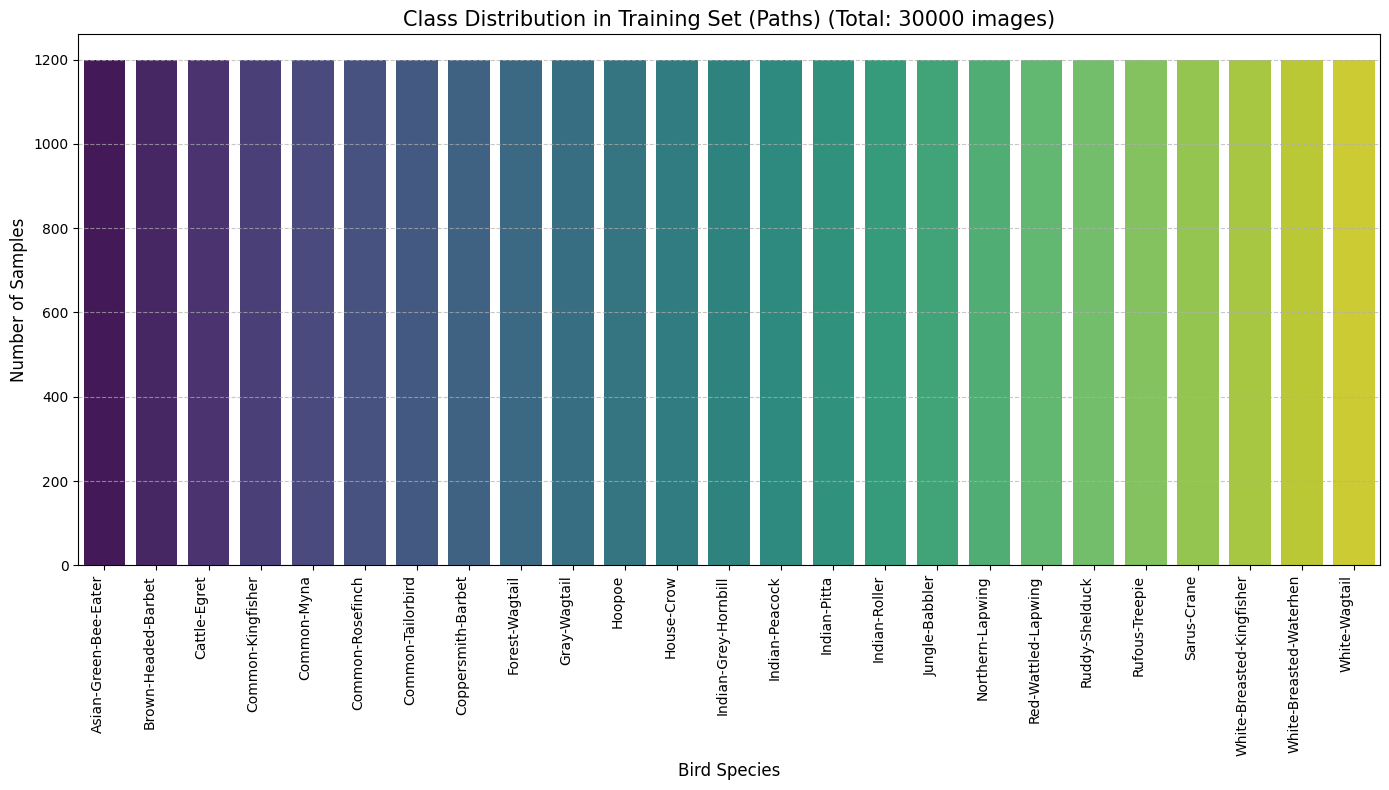

/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


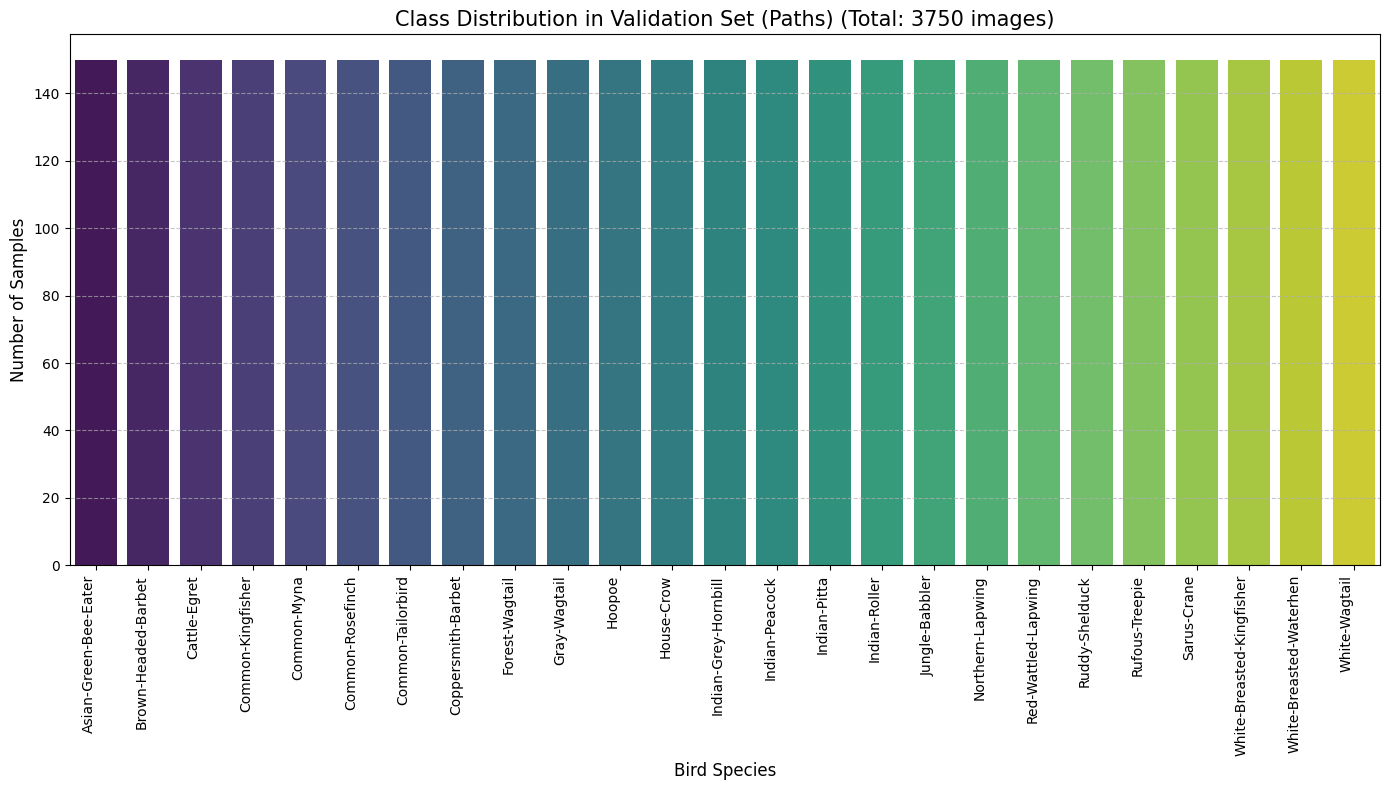

/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


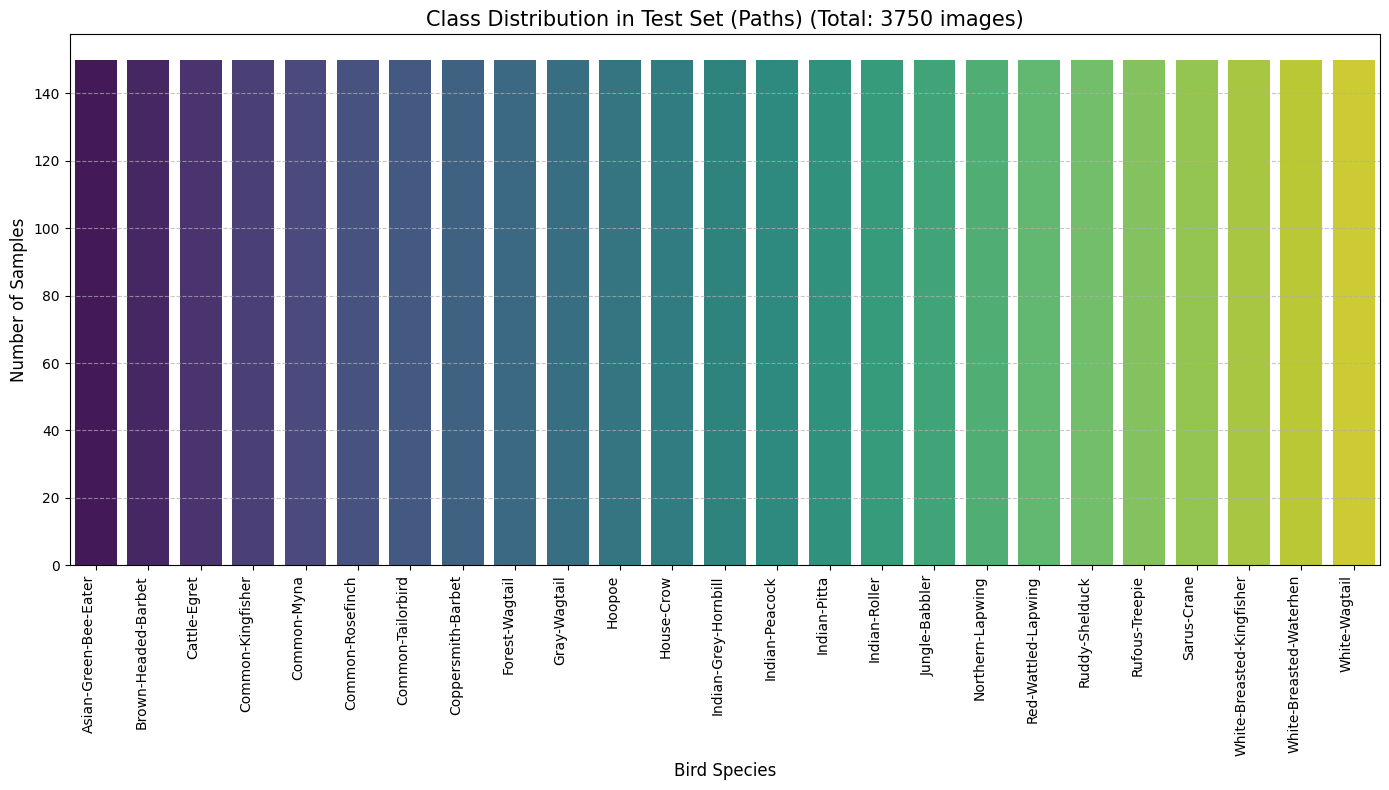

In [26]:

# %% [markdown]
# These visualizations use `load_raw_image_from_path` to show images closer to their original state.

# %% Step 5 Execution
if X_train_paths: # Check if paths were collected
    print("\n--- Displaying Sample Raw Images from Training Paths ---")
    display_sample_images_from_paths(X_train_paths, y_train_labels_encoded, label_mapping,
                                     num_samples_per_class=2, num_classes_to_display=3, title_prefix="Sample Raw Train")

    print("\n--- Displaying Downscaling Effect (using one training sample) ---")
    if X_train_paths:
         show_downscaling_effect_from_path(X_train_paths[0], IMG_WIDTH, IMG_HEIGHT)

    print("\n--- Displaying Color Histograms for a few Raw Training Samples ---")
    if len(X_train_paths) >=2:
        for i in range(2): # Show for 2 samples
            idx = random.randint(0, len(X_train_paths)-1)
            sample_path = X_train_paths[idx]
            raw_img = load_raw_image_from_path(sample_path)
            if raw_img is not None:
                species_name = label_mapping.get(y_train_labels_encoded[idx], "Unknown")
                plot_color_histograms_for_raw_image(raw_img, title=f"Color Histograms for Raw '{species_name}' Sample")
else:
    print("X_train_paths is empty. Skipping raw data visualizations.")


print("\n--- Plotting Class Distributions (based on path counts) ---")
if y_train_labels_encoded.size > 0:
    plot_class_distribution(y_train_labels_encoded, label_mapping, "Training Set (Paths)")
if y_val_labels_encoded.size > 0:
    plot_class_distribution(y_val_labels_encoded, label_mapping, "Validation Set (Paths)")
if y_test_labels_encoded.size > 0:
    plot_class_distribution(y_test_labels_encoded, label_mapping, "Test Set (Paths)")



### Step 6: Load and Preprocess All Data for Model Input



--- Loading and Preprocessing TRAINING Data for Model ---
Starting to load and preprocess 30000 images...
  Processed 500/30000 images for current set.
  Processed 1000/30000 images for current set.
  Processed 1500/30000 images for current set.
  Processed 2000/30000 images for current set.
  Processed 2500/30000 images for current set.
  Processed 3000/30000 images for current set.
  Processed 3500/30000 images for current set.
  Processed 4000/30000 images for current set.
  Processed 4500/30000 images for current set.
  Processed 5000/30000 images for current set.
  Processed 5500/30000 images for current set.
  Processed 6000/30000 images for current set.
  Processed 6500/30000 images for current set.
  Processed 7000/30000 images for current set.
  Processed 7500/30000 images for current set.
  Processed 8000/30000 images for current set.
  Processed 8500/30000 images for current set.
  Processed 9000/30000 images for current set.
  Processed 9500/30000 images for current set.
 

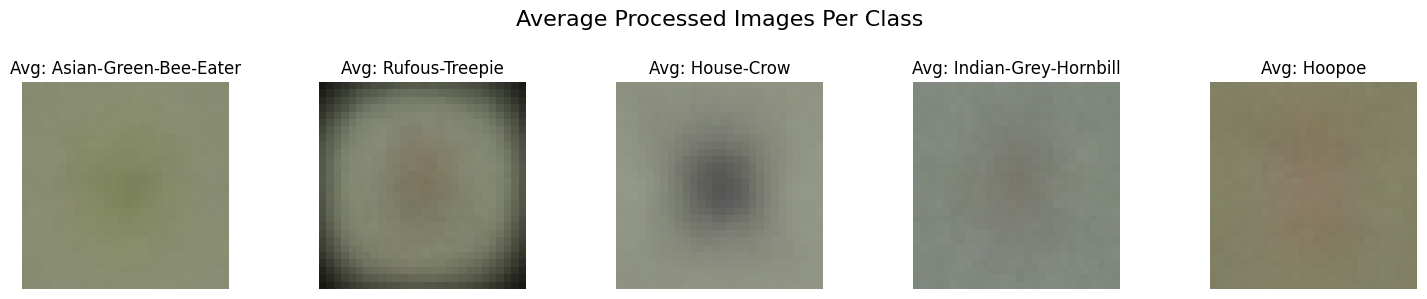


--- Displaying t-SNE of PROCESSED Training Data (subset) ---

Performing t-SNE on a subset of 1000 processed samples...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_136656/1015853115.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', len(unique_labels_in_subset))


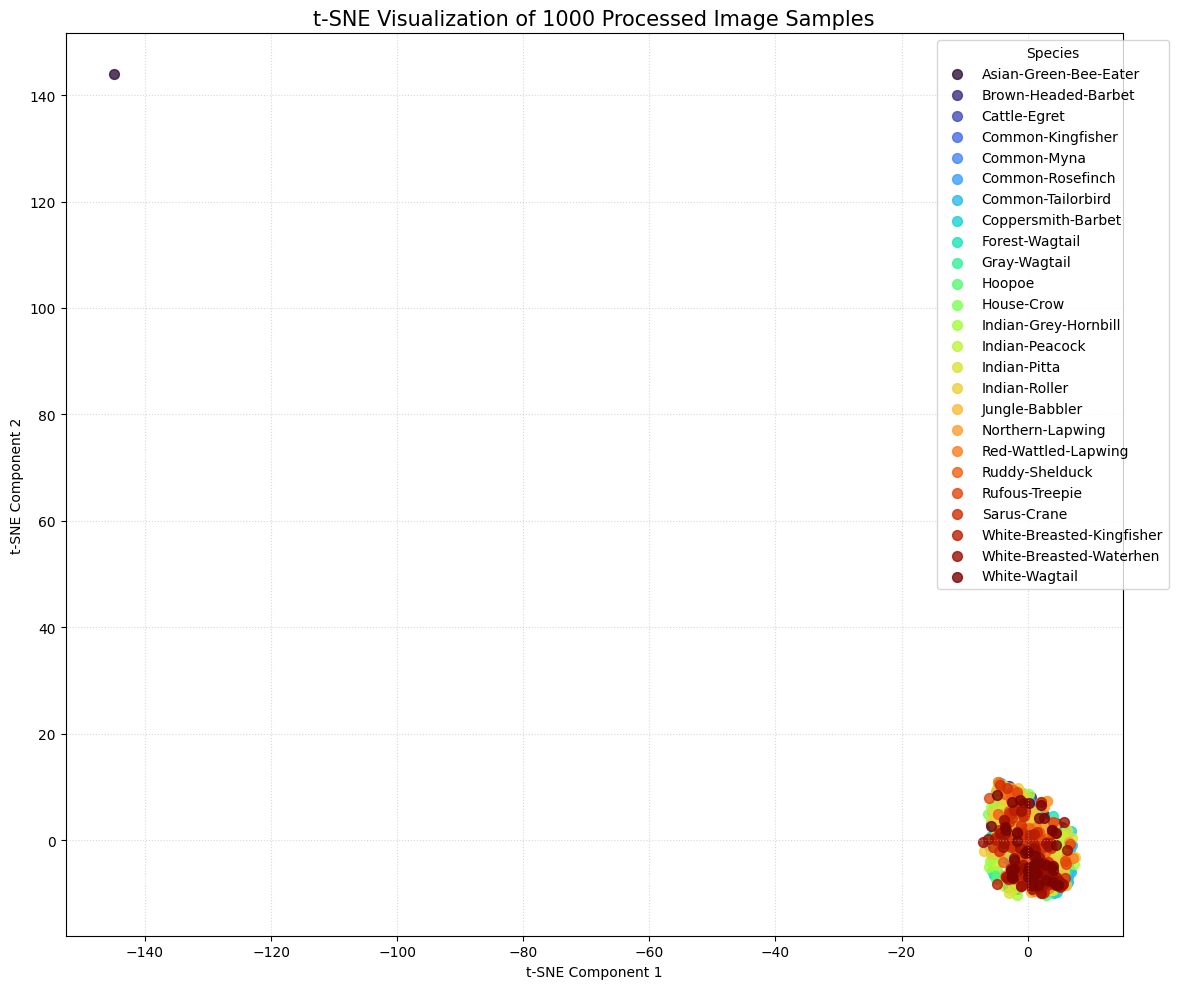


--- End of Data Loading, Preprocessing, and Visualization Script ---


In [27]:

# %% [markdown]
# This step will create `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test` NumPy arrays with images resized and normalized.
# **WARNING: This can be time-consuming and memory-intensive!**

# %% Step 6 Execution
X_train, y_train, X_val, y_val, X_test, y_test = (np.array([]),)*6 # Initialize empty

if X_train_paths and y_train_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TRAINING Data for Model ---")
    X_train, y_train = load_and_preprocess_data_separated(X_train_paths, y_train_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Training data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
else:
    print("Skipping Training data loading due to missing paths or labels.")

if X_val_paths and y_val_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing VALIDATION Data for Model ---")
    X_val, y_val = load_and_preprocess_data_separated(X_val_paths, y_val_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Validation data shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")
else:
    print("Skipping Validation data loading due to missing paths or labels.")

if X_test_paths and y_test_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TEST Data for Model ---")
    X_test, y_test = load_and_preprocess_data_separated(X_test_paths, y_test_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Test data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("Skipping Test data loading due to missing paths or labels.")

# Optional: One-hot encode labels for CNNs (if needed later)
# y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
# y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
# y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
# print(f"\nExample one-hot encoded y_train_cat shape: {y_train_cat.shape if y_train_cat.size > 0 else 'N/A'}")


# %% [markdown]
# ## Step 7: Execute Visualizations of Processed Data (Model Input Data)
# These visualizations operate on the `X_train`, etc., arrays which contain images resized to `IMG_WIDTH`x`IMG_HEIGHT` and normalized.

# %% Step 7 Execution
if X_train.size > 0 and y_train.size > 0:
    print("\n--- Displaying Average PROCESSED Images (from X_train) ---")
    display_average_processed_images(X_train, y_train, label_mapping, num_classes_to_display=5)

    print("\n--- Displaying t-SNE of PROCESSED Training Data (subset) ---")
    # Adjust n_samples_subset and perplexity_val as needed.
    # Perplexity should be less than n_samples_subset - 1.
    plot_tsne_visualization_of_processed(X_train, y_train, label_mapping,
                                         n_samples_subset=1000, perplexity_val=30) # Reduced for speed
else:
    print("X_train or y_train is empty. Skipping visualizations of processed data.")

print("\n--- End of Data Loading, Preprocessing, and Visualization Script ---")

## Part 1: Classification According to Feature Extraction

### Part 1.1: Imports

--- Visualizing Feature Extraction for a Sample Image (with Gabor) ---
Selected image for visualization: Birds_25/train/White-Breasted-Kingfisher/White-Breasted-Kingfisher_1331.jpg
Resized image dimensions: (28, 28, 3)

--- HSV Histogram Visualization ---


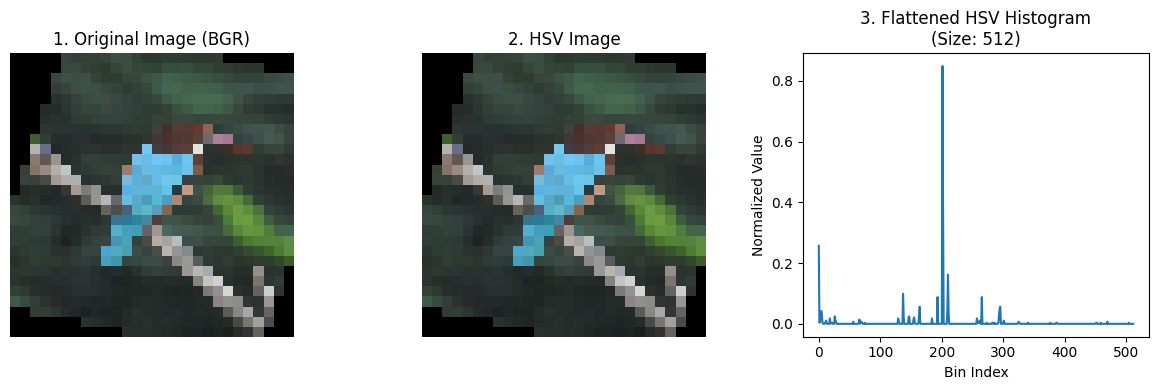


--- HoG Features Visualization ---


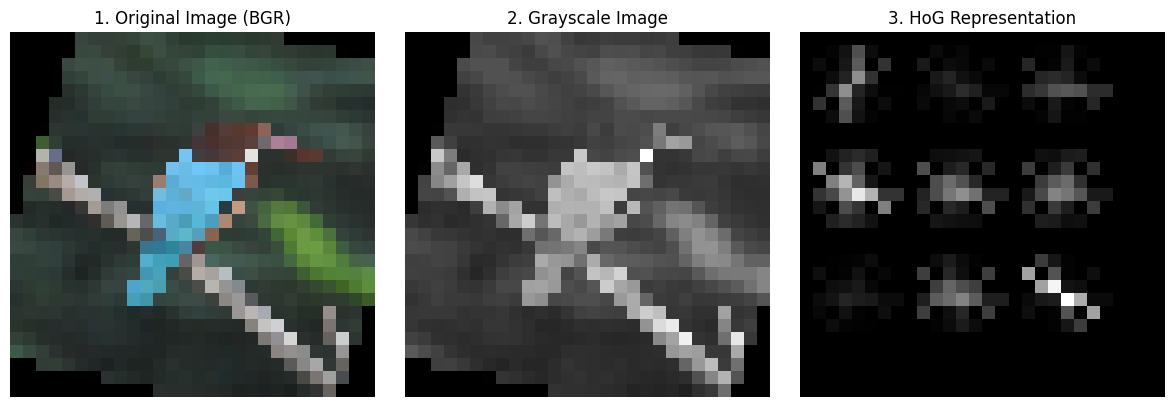

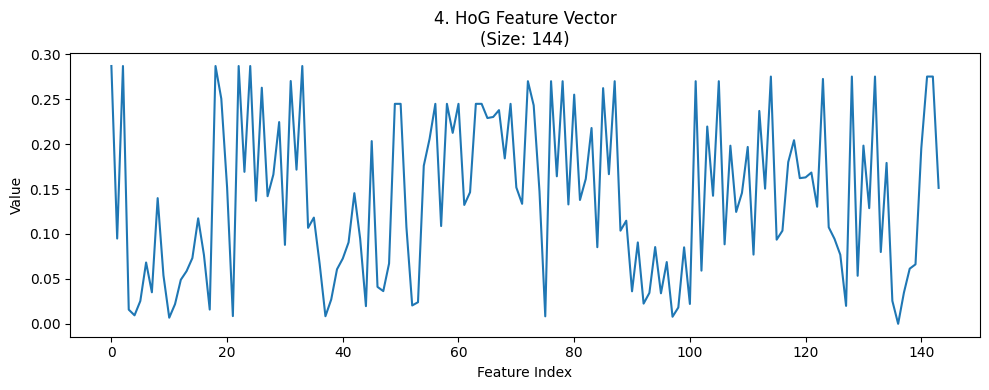


--- Gabor Filter Features Visualization ---


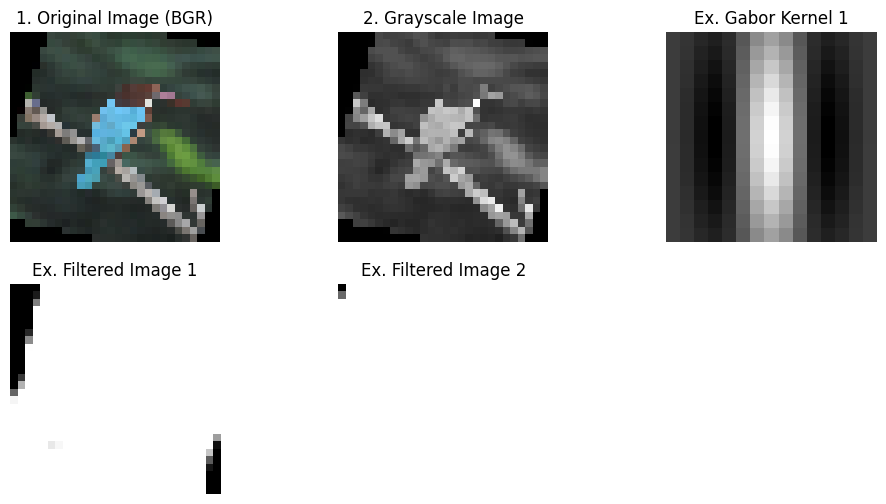

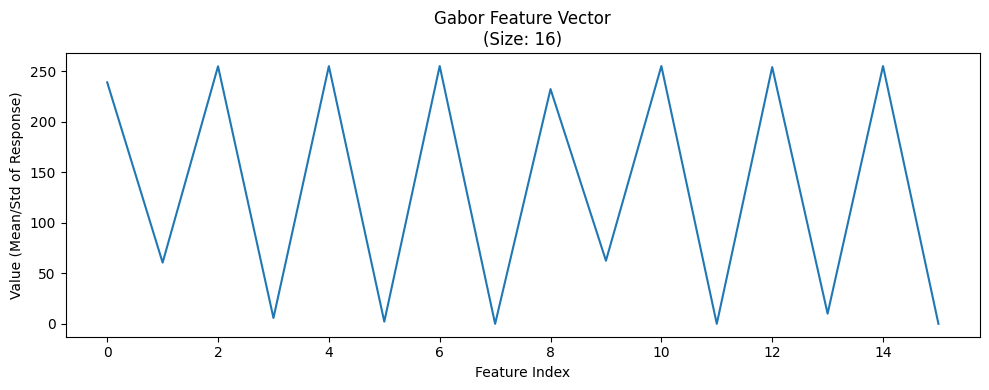


Extracting HSV features...
Starting feature extraction with extract_hsv_histogram_visualized_en for 30000 images...
  Processed 500/30000 images.
  Processed 1000/30000 images.
  Processed 1500/30000 images.
  Processed 2000/30000 images.
  Processed 2500/30000 images.
  Processed 3000/30000 images.
  Processed 3500/30000 images.
  Processed 4000/30000 images.
  Processed 4500/30000 images.
  Processed 5000/30000 images.
  Processed 5500/30000 images.
  Processed 6000/30000 images.
  Processed 6500/30000 images.
  Processed 7000/30000 images.
  Processed 7500/30000 images.
  Processed 8000/30000 images.
  Processed 8500/30000 images.
  Processed 9000/30000 images.
  Processed 9500/30000 images.
  Processed 10000/30000 images.
  Processed 10500/30000 images.
  Processed 11000/30000 images.
  Processed 11500/30000 images.
  Processed 12000/30000 images.
  Processed 12500/30000 images.
  Processed 13000/30000 images.
  Processed 13500/30000 images.
  Processed 14000/30000 images.
  Proce

/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [35]:
# %% [markdown]
# # Part 1: Classification According to Feature Extraction (Using Gabor Filters and Corrected Label Handling)

# %% [markdown]
# In this part, we will extract features from the images using traditional methods:
# 1. Color Histogram (HSV)
# 2. Histogram of Oriented Gradients (HoG)
# 3. Gabor Filters
#
# Then, we will apply at least three basic Machine Learning algorithms to classify the bird species based on these extracted features separately.
# We'll try:
# 1. Logistic Regression
# 2. Support Vector Machine (SVM)
# 3. Random Forest Classifier

# %% Setup: Additional Imports for Part 1
from skimage.feature import hog, local_binary_pattern # hog for HoG, local_binary_pattern is not used now
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB # Added as a third classifier option
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import time
# cv2, numpy, matplotlib.pyplot should already be imported from Part 0

# Ensure your global parameters like IMG_WIDTH, IMG_HEIGHT are set from earlier cells
# For example, if not set previously, define them (use values from your notebook):
# IMG_WIDTH = 128
# IMG_HEIGHT = 128
# label_mapping should also be available from Part 0

# %% --- Feature Extraction with Visualization Functions (English) ---
# (These are the extract_hsv_histogram_visualized_en, extract_hog_features_visualized_en,
# and extract_gabor_features_visualized_en functions from the previous response.
# Copy them here if they are not already in a utility cell in your notebook.)

def extract_hsv_histogram_visualized_en(image_bgr, bins=(8, 8, 8), display_visuals=True):
    """
    Extracts the HSV color histogram from an image and visualizes the steps.
    The input image should be in BGR format.
    """
    if image_bgr is None:
        print("Error: Image could not be loaded (HSV Histogram).")
        return None

    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')

    hsv_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)) # Convert for better display
        plt.title("2. HSV Image")
        plt.axis('off')

    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    flat_hist = hist.flatten()

    if display_visuals:
        plt.subplot(1, 3, 3)
        plt.plot(flat_hist)
        plt.title(f"3. Flattened HSV Histogram\n(Size: {flat_hist.shape[0]})")
        plt.xlabel("Bin Index")
        plt.ylabel("Normalized Value")
        plt.tight_layout()
        plt.show()
    return flat_hist

def extract_hog_features_visualized_en(image_bgr, pixels_per_cell=(8, 8),
                                       cells_per_block=(2, 2), orientations=9,
                                       display_visuals=True):
    """
    Extracts HoG features from an image and visualizes the steps.
    The input image should be in BGR format.
    """
    if image_bgr is None:
        print("Error: Image could not be loaded (HoG).")
        return None

    if display_visuals:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')

    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    if display_visuals:
        plt.subplot(1, 3, 2)
        plt.imshow(gray_image, cmap='gray')
        plt.title("2. Grayscale Image")
        plt.axis('off')

    features, hog_image_visualization = hog(gray_image, orientations=orientations,
                                           pixels_per_cell=pixels_per_cell,
                                           cells_per_block=cells_per_block,
                                           block_norm='L2-Hys',
                                           visualize=True,
                                           transform_sqrt=True)

    if display_visuals:
        if hog_image_visualization is not None and hog_image_visualization.max() > 0:
            hog_image_rescaled = hog_image_visualization / hog_image_visualization.max()
        else:
            hog_image_rescaled = hog_image_visualization

        plt.subplot(1, 3, 3)
        if hog_image_rescaled is not None:
            plt.imshow(hog_image_rescaled, cmap='gray')
        plt.title("3. HoG Representation")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.plot(features)
        plt.title(f"4. HoG Feature Vector\n(Size: {features.shape[0]})")
        plt.xlabel("Feature Index")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()

    return features

def build_gabor_filters(ksize=(31, 31), sigma=5.0, lambd=10.0, gamma=0.5, psi=0): # Renamed to avoid conflict
    g_filters = [] # Renamed local variable
    thetas = np.arange(0, np.pi, np.pi / 4)
    lambdas = [lambd, lambd * 2]

    for theta_val in thetas:
        for lambda_val in lambdas:
            kern = cv2.getGaborKernel(ksize, sigma, theta_val, lambda_val, gamma, psi, ktype=cv2.CV_32F)
            g_filters.append(kern)
    return g_filters

def process_with_gabor_filters(image_gray, gabor_filters_list): # Renamed to avoid conflict
    gabor_features_list = [] # Renamed local variable
    filtered_imgs_list = [] # Renamed local variable
    for i, kern in enumerate(gabor_filters_list):
        fimg = cv2.filter2D(image_gray, cv2.CV_8UC3, kern)
        gabor_features_list.extend([fimg.mean(), fimg.std()])
        if i < 4:
             filtered_imgs_list.append(fimg)
    return np.array(gabor_features_list), filtered_imgs_list


def extract_gabor_features_visualized_en(image_bgr, display_visuals=True):
    """
    Extracts Gabor filter features from an image and visualizes the steps.
    """
    if image_bgr is None:
        print("Error: Image could not be loaded (Gabor).")
        return None

    ksize = (15, 15)
    sigma = 3.0
    lambd = 10.0
    gamma = 0.5
    psi = 0

    gabor_kernels_bank = build_gabor_filters(ksize=ksize, sigma=sigma, lambd=lambd, gamma=gamma, psi=psi) # Use renamed helper

    if display_visuals:
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title("1. Original Image (BGR)")
        plt.axis('off')

    gray_image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    if display_visuals:
        plt.subplot(2, 3, 2)
        plt.imshow(gray_image, cmap='gray')
        plt.title("2. Grayscale Image")
        plt.axis('off')

        if len(gabor_kernels_bank) >= 2:
            plt.subplot(2, 3, 3)
            plt.imshow(gabor_kernels_bank[0], cmap='gray')
            plt.title("Ex. Gabor Kernel 1")
            plt.axis('off')

    gabor_feature_vector, example_filtered_images = process_with_gabor_filters(gray_image, gabor_kernels_bank) # Use renamed helper

    if display_visuals:
        if len(example_filtered_images) >= 1:
            plt.subplot(2, 3, 4)
            plt.imshow(example_filtered_images[0], cmap='gray')
            plt.title("Ex. Filtered Image 1")
            plt.axis('off')
        if len(example_filtered_images) >= 2:
            plt.subplot(2, 3, 5)
            plt.imshow(example_filtered_images[1], cmap='gray')
            plt.title("Ex. Filtered Image 2")
            plt.axis('off')

        plt.figure(figsize=(10,4))
        plt.plot(gabor_feature_vector)
        plt.title(f"Gabor Feature Vector\n(Size: {gabor_feature_vector.shape[0]})")
        plt.xlabel("Feature Index")
        plt.ylabel("Value (Mean/Std of Response)")
        plt.tight_layout()
        plt.show()

    return gabor_feature_vector

# %% --- Part 1: Feature Extraction Visualization Example (with Gabor) ---
print("--- Visualizing Feature Extraction for a Sample Image (with Gabor) ---")

# Assuming X_train_paths, IMG_WIDTH, IMG_HEIGHT are defined from your notebook's Part 0
if 'X_train_paths' in globals() and X_train_paths: #
    sample_image_path_for_viz = random.choice(X_train_paths) #
    print(f"Selected image for visualization: {sample_image_path_for_viz}")

    img_bgr_raw_viz = cv2.imread(sample_image_path_for_viz) # cv2.imread reads in BGR
    
    if img_bgr_raw_viz is not None:
        img_bgr_resized_viz = cv2.resize(img_bgr_raw_viz, (IMG_WIDTH, IMG_HEIGHT)) #
        print(f"Resized image dimensions: {img_bgr_resized_viz.shape}")

        print("\n--- HSV Histogram Visualization ---")
        _ = extract_hsv_histogram_visualized_en(img_bgr_resized_viz.copy(), display_visuals=True)
        
        print("\n--- HoG Features Visualization ---")
        _ = extract_hog_features_visualized_en(img_bgr_resized_viz.copy(), pixels_per_cell=(8,8), cells_per_block=(2,2), display_visuals=True)
        
        print("\n--- Gabor Filter Features Visualization ---")
        _ = extract_gabor_features_visualized_en(img_bgr_resized_viz.copy(), display_visuals=True)
    else:
        print(f"Error: Could not load sample image for visualization - {sample_image_path_for_viz}")
else:
    print("Training image paths (X_train_paths) not found for visualization.")


# %% --- Part 1: UPDATED Function to Extract Features and Filter Labels ---
def extract_features_and_filter_labels(image_paths, original_labels, feature_extractor_func, **kwargs):
    features_list = []
    valid_labels_list = []
    print(f"Starting feature extraction with {feature_extractor_func.__name__} for {len(image_paths)} images...")
    for i, img_path in enumerate(image_paths):
        img_bgr_raw = cv2.imread(img_path)
        if img_bgr_raw is None:
            print(f"Warning: Could not load {img_path} at index {i}, skipping.")
            continue
        
        img_bgr_resized = cv2.resize(img_bgr_raw, (IMG_WIDTH, IMG_HEIGHT))
        
        features = feature_extractor_func(img_bgr_resized.copy(), display_visuals=False, **kwargs)
        if features is not None:
            features_list.append(features)
            valid_labels_list.append(original_labels[i]) # Add corresponding label
        else:
            print(f"Warning: Feature extraction returned None for {img_path} at index {i}, skipping.")

        if (i + 1) % 500 == 0 or (i + 1) == len(image_paths):
            print(f"  Processed {i+1}/{len(image_paths)} images.")
            
    print(f"Finished. Successfully extracted features for {len(features_list)} out of {len(image_paths)} images.")
    return np.array(features_list), np.array(valid_labels_list)

# %% --- Part 1: Extracting All Features for Train, Validation, and Test Sets (with Corrected Label Handling) ---

# Ensure X_train_paths, y_train_labels_encoded, etc. are loaded from your Part 0
X_train_paths_run = X_train_paths #
y_train_labels_original_run = y_train_labels_encoded # Use the original encoded labels from Part 0
X_val_paths_run = X_val_paths #
y_val_labels_original_run = y_val_labels_encoded #
X_test_paths_run = X_test_paths #
y_test_labels_original_run = y_test_labels_encoded #

# HSV Features
print("\nExtracting HSV features...")
X_train_hsv, y_train_hsv = extract_features_and_filter_labels(X_train_paths_run, y_train_labels_original_run, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_val_hsv, y_val_hsv = extract_features_and_filter_labels(X_val_paths_run, y_val_labels_original_run, extract_hsv_histogram_visualized_en, bins=(8,8,8))
X_test_hsv, y_test_hsv = extract_features_and_filter_labels(X_test_paths_run, y_test_labels_original_run, extract_hsv_histogram_visualized_en, bins=(8,8,8))

# HoG Features
print("\nExtracting HoG features...")
X_train_hog, y_train_hog = extract_features_and_filter_labels(X_train_paths_run, y_train_labels_original_run, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_val_hog, y_val_hog = extract_features_and_filter_labels(X_val_paths_run, y_val_labels_original_run, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)
X_test_hog, y_test_hog = extract_features_and_filter_labels(X_test_paths_run, y_test_labels_original_run, extract_hog_features_visualized_en, pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9)

# Gabor Features
print("\nExtracting Gabor features...")
X_train_gabor, y_train_gabor = extract_features_and_filter_labels(X_train_paths_run, y_train_labels_original_run, extract_gabor_features_visualized_en)
X_val_gabor, y_val_gabor = extract_features_and_filter_labels(X_val_paths_run, y_val_labels_original_run, extract_gabor_features_visualized_en)
X_test_gabor, y_test_gabor = extract_features_and_filter_labels(X_test_paths_run, y_test_labels_original_run, extract_gabor_features_visualized_en)

print("\n--- Feature Extraction and Corresponding Label Shapes ---")
if X_train_hsv.size > 0: print(f"X_train_hsv shape: {X_train_hsv.shape}, y_train_hsv shape: {y_train_hsv.shape}")
if X_val_hsv.size > 0: print(f"X_val_hsv shape: {X_val_hsv.shape}, y_val_hsv shape: {y_val_hsv.shape}")
if X_test_hsv.size > 0: print(f"X_test_hsv shape: {X_test_hsv.shape}, y_test_hsv shape: {y_test_hsv.shape}")

if X_train_hog.size > 0: print(f"X_train_hog shape: {X_train_hog.shape}, y_train_hog shape: {y_train_hog.shape}")
if X_val_hog.size > 0: print(f"X_val_hog shape: {X_val_hog.shape}, y_val_hog shape: {y_val_hog.shape}")
if X_test_hog.size > 0: print(f"X_test_hog shape: {X_test_hog.shape}, y_test_hog shape: {y_test_hog.shape}")

if X_train_gabor.size > 0: print(f"X_train_gabor shape: {X_train_gabor.shape}, y_train_gabor shape: {y_train_gabor.shape}")
if X_val_gabor.size > 0: print(f"X_val_gabor shape: {X_val_gabor.shape}, y_val_gabor shape: {y_val_gabor.shape}")
if X_test_gabor.size > 0: print(f"X_test_gabor shape: {X_test_gabor.shape}, y_test_gabor shape: {y_test_gabor.shape}")

# %% --- Part 1: Training and Evaluating ML Models (Using Corrected Labels) ---

# Store features and their corresponding filtered labels in dictionaries
# The value is now a tuple: (feature_array, label_array)
feature_data_train = {
    "HSV": (X_train_hsv, y_train_hsv),
    "HoG": (X_train_hog, y_train_hog),
    "Gabor": (X_train_gabor, y_train_gabor)
}
feature_data_val = {
    "HSV": (X_val_hsv, y_val_hsv),
    "HoG": (X_val_hog, y_val_hog),
    "Gabor": (X_val_gabor, y_val_gabor)
}
feature_data_test = {
    "HSV": (X_test_hsv, y_test_hsv),
    "HoG": (X_test_hog, y_test_hog),
    "Gabor": (X_test_gabor, y_test_gabor)
}

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver='saga', multi_class='multinomial', C=0.1, random_state=42, n_jobs=-1),
    "SVM (Linear Kernel)": SVC(kernel='linear', C=0.1, probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1),
    "Gaussian Naive Bayes": GaussianNB()
}

# Ensure target_names_part1 is defined (should be from your Part 0 using label_mapping)
if 'label_mapping' in globals(): #
    target_names_part1 = [label_mapping[i] for i in sorted(label_mapping.keys())] #
else:
    print("Warning: label_mapping not found. Classification report will use numerical labels.")
    # Create a default if NUM_CLASSES is defined
    target_names_part1 = [str(i) for i in range(NUM_CLASSES)] if 'NUM_CLASSES' in globals() else None #


results_part1_final = [] # Use a new list for results

for feature_name, (X_train_feat, y_train_feat_filt) in feature_data_train.items():
    X_val_feat, y_val_feat_filt = feature_data_val[feature_name]
    X_test_feat, y_test_feat_filt = feature_data_test[feature_name]

    if X_train_feat.size == 0 or y_train_feat_filt.size == 0 or \
       X_val_feat.size == 0 or y_val_feat_filt.size == 0 or \
       X_test_feat.size == 0 or y_test_feat_filt.size == 0:
        print(f"\nSkipping {feature_name} features due to empty feature set or labels after filtering.")
        continue
        
    if X_train_feat.shape[0] != y_train_feat_filt.shape[0] or \
       X_val_feat.shape[0] != y_val_feat_filt.shape[0] or \
       X_test_feat.shape[0] != y_test_feat_filt.shape[0]:
        print(f"CRITICAL MISMATCH for {feature_name} even after filtering. Skipping this set.")
        print(f"Train shapes: X-{X_train_feat.shape}, y-{y_train_feat_filt.shape}")
        print(f"Val shapes: X-{X_val_feat.shape}, y-{y_val_feat_filt.shape}")
        print(f"Test shapes: X-{X_test_feat.shape}, y-{y_test_feat_filt.shape}")
        continue

    print(f"\n===== Evaluating ML Models with {feature_name} Features (Samples: Train-{X_train_feat.shape[0]}, Val-{X_val_feat.shape[0]}, Test-{X_test_feat.shape[0]}) =====")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_feat)
    X_val_scaled = scaler.transform(X_val_feat)
    X_test_scaled = scaler.transform(X_test_feat)

    for model_name, model_instance_orig in ml_models.items():
        print(f"\n--- Training {model_name} with {feature_name} ---")
        start_time = time.time()
        
        # Create a new instance of the model for each feature set to avoid refitting issues
        current_model = type(model_instance_orig)(**model_instance_orig.get_params())
        if 'random_state' in current_model.get_params(): # Ensure reproducibility for models that support it
            current_model.set_params(random_state=42)

        try:
            current_model.fit(X_train_scaled, y_train_feat_filt) # Use filtered labels
            train_time = time.time() - start_time

            # Evaluate on Validation Set
            y_val_pred = current_model.predict(X_val_scaled)
            val_accuracy = accuracy_score(y_val_feat_filt, y_val_pred) # Use filtered labels
            val_report_dict = classification_report(y_val_feat_filt, y_val_pred, target_names=target_names_part1, output_dict=True, zero_division=0, labels = np.unique(y_train_feat_filt))
            print(f"Validation Accuracy: {val_accuracy:.4f}")

            # Evaluate on Test Set
            start_test_time = time.time()
            y_test_pred = current_model.predict(X_test_scaled)
            test_time = time.time() - start_test_time
            
            test_accuracy = accuracy_score(y_test_feat_filt, y_test_pred) # Use filtered labels
            test_report_str = classification_report(y_test_feat_filt, y_test_pred, target_names=target_names_part1, zero_division=0, labels = np.unique(y_train_feat_filt))
            test_report_dict = classification_report(y_test_feat_filt, y_test_pred, target_names=target_names_part1, output_dict=True, zero_division=0, labels = np.unique(y_train_feat_filt))
            
            print(f"Test Accuracy: {test_accuracy:.4f}")
            print("Test Set Classification Report:")
            print(test_report_str)
            
            results_part1_final.append({
                "Feature Set": feature_name,
                "ML Model": model_name,
                "Validation Accuracy": round(val_accuracy, 4),
                "Test Accuracy": round(test_accuracy, 4),
                "Test Precision (macro)": round(test_report_dict['macro avg']['precision'], 4),
                "Test Recall (macro)": round(test_report_dict['macro avg']['recall'], 4),
                "Test F1-Score (macro)": round(test_report_dict['macro avg']['f1-score'], 4),
                "Training Time (s)": round(train_time, 2),
                "Test Time (s)": round(test_time, 2)
            })
        except Exception as e:
            print(f"Error training/evaluating {model_name} with {feature_name}: {e}")

# %% --- Part 1: Displaying Final Results ---
print("\n\n--- Summary of Part 1 Results (HSV, HoG, Gabor - Corrected Labels) ---")
df_results_part1_final = pd.DataFrame(results_part1_final)
if not df_results_part1_final.empty:
    df_results_part1_sorted_final = df_results_part1_final.sort_values(by="Test Accuracy", ascending=False)
    print(df_results_part1_sorted_final.to_string())
else:
    print("No results to display for Part 1 (Corrected). Check for errors during feature extraction or model training.")

# %% [markdown]
# ## Part 1: Comments and Interpretations (with Gabor and Corrected Labels)
#
# * **Feature Extraction Methods:** Briefly discuss each method (HSV, HoG, Gabor). What kind of information does each capture?
# * **ML Algorithms:** Briefly describe the ML algorithms used (Logistic Regression, SVM, Random Forest, Gaussian Naive Bayes).
# * **Performance Comparison:**
#     * Which feature set performed best overall on the test set? Why do you think that is?
#     * Which ML algorithm performed best overall? Was its performance consistent across different feature sets?
#     * Were there any feature set + ML algorithm combinations that performed particularly well or poorly?
#     * Comment on the training and testing times. Were there significant differences?
# * **Challenges:** What challenges did you face in this part? (e.g., feature vector dimensionality, computational time, label mismatch issue and its resolution).
# * **Misclassifications (Extra):**
#     * Based on your best performing traditional model from this part, try to identify a few misclassified images from the test set.
#     * Discuss potential reasons for these misclassifications (e.g., visual similarity between species, challenging image conditions like pose/lighting/occlusion, limitations of the feature extractor).
#
# *(Please fill in your detailed comments and interpretations here based on the results you obtain.)*

### Part 1.2: Feature Extraction Funcitons with Visualization Functions


### Part 1.4: Feature Extraction Methods Visualized

### Part 1.5: Running The Experiment